In [0]:
!pip install pydrive

    100% |████████████████████████████████| 993kB 14.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:

import numpy as np
import json
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import tensorflow as tf
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'1LYvb3OMwbKUgjViakvkHycYXSMpOx02x' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Team11_Boeing.json, id: 1oBUOiWS5AlapafCe80XsyW0yzRGDuROk
title: glove.6B.300d.txt, id: 1DBXDDm1cHVwqjoQpSpmc3Xn2w8bJhI81
title: glove.6B.200d.txt, id: 1SLw14eCap4C03Rh9_SpYbXGCXBTAtFw4
title: glove.6B.100d.txt, id: 1B-VAxihJke7NXxhSLoHkqBfqARQ5GFq6
title: glove.6B.50d.txt, id: 12OnMdsv07C1V4ZGvQ4prqr5joIGqOPEk


In [0]:
glove_file = drive.CreateFile({'id': '1B-VAxihJke7NXxhSLoHkqBfqARQ5GFq6'})
glove_file.GetContentFile('glove.6B.100d.txt')
json_file = drive.CreateFile({'id': '1oBUOiWS5AlapafCe80XsyW0yzRGDuROk'})
json_file.GetContentFile('Team11_Boeing.json')

## Creating the word embedding

In [0]:
# embeddings_index = {}
# f = open('glove.6B.100d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()
from nltk.corpus import stopwords

NB_WORDS = 10000
emb_dict = {}
glove = open('glove.6B.100d.txt')
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()
print('Found %s word vectors.' % len(emb_dict))

In [0]:
GLOVE_DIM = 100
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))
for w, i in tokenize.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
          emb_matrix[i] = vect
    else:
        break

In [0]:
import pandas as pd
import numpy as np
import itertools
from keras.preprocessing import text, sequence
from keras import utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [0]:
json_df=pd.read_json("cleanedDataset.json")

In [0]:
json_df['sentiment'].value_counts()

Neutral     780
Positive    608
Negative    147
Name: sentiment, dtype: int64

In [0]:
train_size = int(len(json_df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(json_df) - train_size))

Train size: 1228
Test size: 307


In [0]:
train_posts = json_df['text'][:train_size]
train_tags = json_df['sentiment'][:train_size]

test_posts = json_df['text'][train_size:]
test_tags = json_df['sentiment'][train_size:]

In [0]:
max_words = 250
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [0]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [0]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1228, 250)
x_test shape: (307, 250)
y_train shape: (1228, 3)
y_test shape: (307, 3)


In [0]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 16
epoch = 20

In [0]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
#import keras.callbacks.Callback()
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 100, input_length=max_words))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

model.layers[0].set_weights([emb_matrix])
model.layers[0].trainable = False
# glove_history = deep_model(model, x_train, y_train, X_valid_emb, y_valid_emb)

history = model.fit(x_train, y_train,
                    epochs=epoch,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks=[EarlyStopping()])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 250, 100)          1000000   
_________________________________________________________________
flatten_15 (Flatten)         (None, 25000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 75003     
Total params: 1,075,003
Trainable params: 1,075,003
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 982 samples, validate on 246 samples
Epoch 1/20
982/982 [==============================] - 1s 944us/step - loss: 0.5788 - acc: 0.7295 - val_loss: 0.4706 - val_acc: 0.8144
Epoch 2/20
982/982 [==============================] - 0s 214us/step - loss: 0.4442 - acc: 0.7984 - val_loss: 0.4147 - val_acc: 0.8564
Epoch 3/20
982/982 [==============================] - 0s 202us/step - loss: 0.4173 - acc: 0.8153 - val_loss: 0.4399 - val_acc: 0.8266


In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

307/307 [==============================] - 0s 145us/step
Test score: 0.6360066973813582
Test accuracy: 0.6764386756412369


In [0]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

And building on the speed simplicity and security  ...
Actual label:Positive
Predicted label: Positive

The overall economy is certainly also quite good,  ...
Actual label:Positive
Predicted label: Positive

Weve added new facial recognition capabilities, wh ...
Actual label:Positive
Predicted label: Neutral

Great. Thanks very much. ...
Actual label:Positive
Predicted label: Neutral

Thanks, Brad. We'll take next question now, please ...
Actual label:Neutral
Predicted label: Neutral

Thank you. Our next question is coming from the li ...
Actual label:Neutral
Predicted label: Neutral

Thanks for taking my question. Satya or Amy, can y ...
Actual label:Positive
Predicted label: Neutral

Yeah, I can start and then, yeah. ...
Actual label:Neutral
Predicted label: Neutral

For the full year, we repurchased 13.9 million sha ...
Actual label:Positive
Predicted label: Positive

Why don't you start. ...
Actual label:Neutral
Predicted label: Neutral



In [0]:
y_softmax = model.predict(x_train)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_train)):
    probs = y_train[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

[[ 38  57  36]
 [  4 580  72]
 [  2 107 332]]


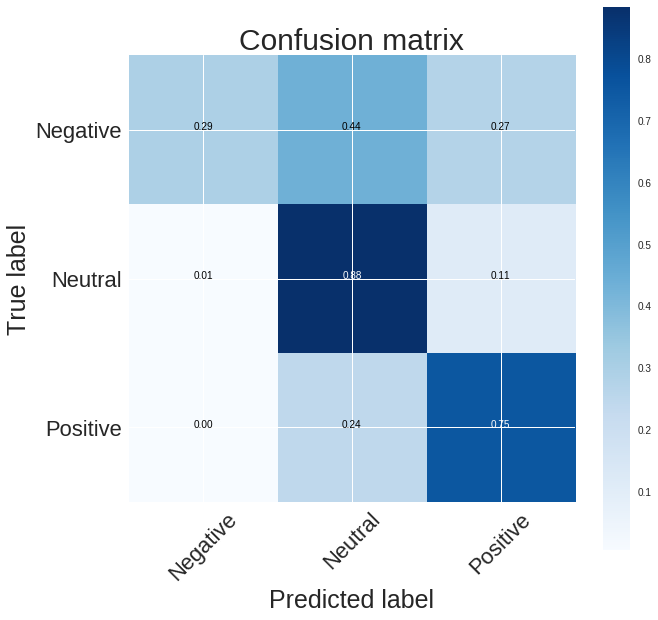

In [0]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
print(cnf_matrix)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## Sentiment analysis on GE

In [0]:
json_df_GE=pd.read_json("generated.json")
json_df_GE['Sentiment'].value_counts()

neutral     137
positive     37
negative      7
Name: Sentiment, dtype: int64

In [0]:
GE_train_size = int(len(json_df_GE) * .8)
print ("Train size: %d" % GE_train_size)
print ("Test size: %d" % (len(json_df_GE) - GE_train_size))

Train size: 144
Test size: 37


## Data Preparation for General Electric earning call transcripts

In [0]:
GE_train_posts = json_df_GE['Text'][:GE_train_size]
GE_train_tags = json_df_GE['Sentiment'][:GE_train_size]

GE_test_posts = json_df_GE['Text'][GE_train_size:]
GE_test_tags = json_df_GE['Sentiment'][GE_train_size:]

In [0]:
max_words = 250
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
tokenize.fit_on_texts(GE_train_posts) # only fit on train
x_train_GE = tokenize.texts_to_matrix(GE_train_posts)
x_test_GE = tokenize.texts_to_matrix(GE_test_posts)

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(GE_train_tags)
y_train_GE = encoder.transform(GE_train_tags)
y_test_GE = encoder.transform(GE_test_tags)

In [0]:
num_classes = np.max(y_train_GE) + 1
y_train_GE = utils.to_categorical(y_train_GE, num_classes)
y_test_GE = utils.to_categorical(y_test_GE, num_classes)

## Creating model using GloVe

In [0]:

GE_model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
GE_model.add(Embedding(10000, 100, input_length=max_words))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
GE_model.add(Flatten())

# We add the classifier on top
GE_model.add(Dense(num_classes, activation='sigmoid'))
GE_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
GE_model.summary()

GE_model.layers[0].set_weights([emb_matrix])
GE_model.layers[0].trainable = False
# glove_history = deep_model(model, x_train, y_train, X_valid_emb, y_valid_emb)

history = GE_model.fit(x_train_GE, y_train_GE,
                    epochs=epoch,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks=[EarlyStopping()])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 250, 100)          1000000   
_________________________________________________________________
flatten_16 (Flatten)         (None, 25000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 75003     
Total params: 1,075,003
Trainable params: 1,075,003
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 115 samples, validate on 29 samples
Epoch 1/20
115/115 [==============================] - 1s 6ms/step - loss: 0.6296 - acc: 0.7652 - val_loss: 0.5642 - val_acc: 0.6322
Epoch 2/20
115/115 [==============================] - 0s 279us/step - loss: 0.3716 - acc: 0.8464 - val_loss: 0.4569 - val_acc: 0.7816
Epoch 3/20
115/115 [==============================] - 0s 256us/step - loss: 0.2302 - acc: 0.9304 - val_loss: 0.4460 - val_acc: 0.7816
Epoch 4/20
115/115 [==============================] - 0s 262us/step - loss: 0.1785 - acc: 0.9594 - val_loss: 0.5327 - val_acc: 0.7931


## Testing Accuracy

In [0]:
GE_score = GE_model.evaluate(x_test_GE, y_test_GE,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

37/37 [==============================] - 0s 448us/step
Test score: 0.6360066973813582
Test accuracy: 0.6764386756412369


In [0]:
y_softmax = model.predict(x_test_GE)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test_GE)):
    probs = y_test_GE[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

## Confusion Matrix for GE

[[ 0  1  1]
 [ 0 18  9]
 [ 0  5  3]]


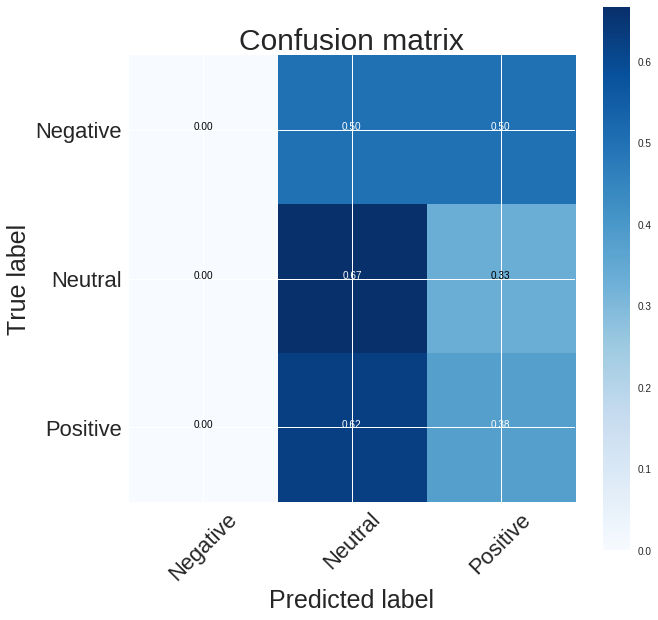

In [0]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
print(cnf_matrix)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()